In [138]:
import numpy as np
import scipy.stats as s
import configparser
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime
from itertools import groupby
import pickle
from collections import namedtuple
from scipy import stats

import re

from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/marat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [110]:
# from run_bot_simple import prepare_dataset
# rows = list(prepare_dataset('downloads/sber3.csv'))

from run_bot_simple import Row
with open('downloads/sber3.csv.pickle', 'rb') as f:
    rows = pickle.load(f)
    
def to_float(x):
    try:
        return float(x)
    except TypeError:
        return np.nan
    

dataset = pd.DataFrame([dict(zip(r._fields, r)) for r in rows])
dataset['discriminator'] = dataset['discriminator'].apply(to_float)

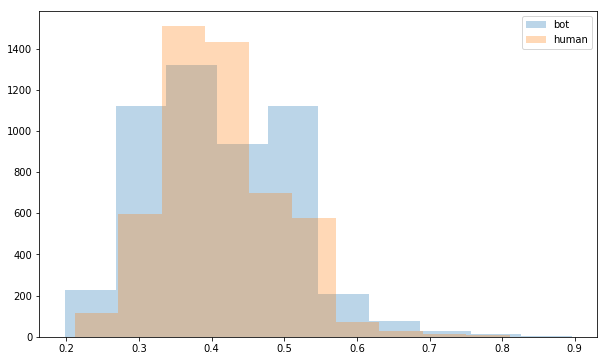

In [111]:
k_bots = dataset['operator'] == 'bot'
k_humans = dataset['operator'] == 'human'
plt.hist(dataset[k_bots]['discriminator'], label='bot', alpha=0.3)
plt.hist(dataset[k_humans]['discriminator'], label='human', alpha=0.3)
plt.legend()
plt.show()

In [114]:
bots = dataset[(dataset['operator']=='bot')]
(bots['discriminator'] >= 0.5).sum(), len((bots))


(1089, 5053)

In [116]:
def by_question(row):
    return row.question

fixed_count = 0
totatl_count = 0

bad_count = 0
good_count = 0

dataset=rows

diffs = []

for group, diff_answers in groupby(sorted([d for d in dataset if d.operator == 'bot'], key=by_question), key=by_question):
    data = list(diff_answers)
    max_score_row = max(data, key=lambda x: float(x.discriminator))
    min_score_row = min(data, key=lambda x: float(x.discriminator))
    max_score = float(max_score_row.discriminator)
    min_score = float(min_score_row.discriminator)
#     print(len(data), max_score-min_score, group)
    is_fixed = min_score < 0.5 < max_score
    if max_score_row.answer == min_score_row.answer:
        continue
#     is_fixed = (max_score - min_score) > 0.1
    
    diffs.append(max_score - min_score)

    if is_fixed:
        print(min_score_row.question)
        print('{:.2f} -> {:.2f}'.format(min_score, max_score))
        print(min_score_row.operator,':', min_score_row.answer)
        print(max_score_row.operator,':', max_score_row.answer)
        print()

    fixed_count += is_fixed
    totatl_count += 1
    bad_count += max_score < 0.5
    good_count += max_score > 0.5
    

print(fixed_count/totatl_count)
print('<0.5: ', bad_count, 'of', totatl_count)
print('>0.5: ', good_count, 'of', totatl_count)
print('fixed: ', fixed_count, 'of', totatl_count)



% комиссии за перевод какой будет ?  
0.44 -> 0.58
bot : Информацию по данному вопросу Вы можете уточнить по номеру телефона .
bot : Информацию по тарифам и оплате Вы можете уточнить , перейдя по ссылке : http : / / data . sberbank . ru / moscow / ru / legal / bankingservice / edbo / tarif / ? base = beta

& amp ; quot ; отсутствует лицевой счет или кор . счет получателя & amp ; quot ; . А посмотреть в платежное поручение .  
0.37 -> 0.56
bot : Необходимо зайти в раздел " Услуги " - " Рублевые операции " - " Платежные поручения " , сверху на панели инструментов нажимаете знак " Воронки " .
bot : Для решения данного вопроса потребуется запросить информацию о Вашей компании . Вам будет удобно в ближайшие 15 минут принять входящий звонок , в режиме которого я Вас проконсультирую ?

* отправлено 217 @ roskran . ru В мобильном приложении у сотрудника она уже отображена , только не активна  
0.31 -> 0.53
bot : В данном случае с расчетного счета Вы проверяли выписку ?
bot : Продолжить консуль

>0.5:  600 of 1586
fixed:  545 of 1586


In [103]:
diffs = np.array(diffs)

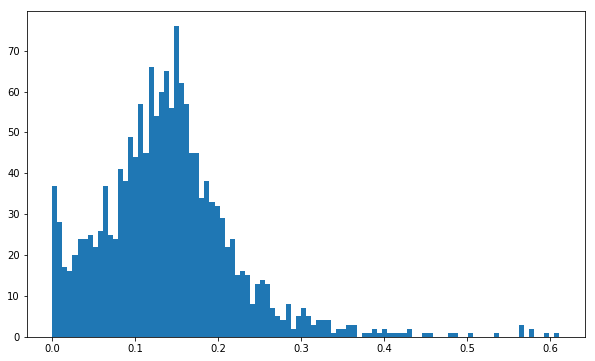

In [105]:
plt.hist(diffs[diffs>=0], bins=100)
plt.show()

In [129]:
data = pd.read_csv('target/sber3_20171127T141129.tsv', sep='\t', na_values='None')

In [130]:
def plot_beta(bot, human, rnd, title='', legend=True):
    neg, pos = bot
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'bot {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'r-', lw=5, alpha=0.6, label=label)

    neg, pos = human
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'human {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'g-', lw=5, alpha=0.6, label=label)
       
    neg, pos = rnd
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'random {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'b-', lw=5, alpha=0.6, label=label)
    
    
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    plt.title('{} (Fisher test z={:.3f}, pvalue={:.4f})'.format(title, *ztest))
    if legend:
        plt.legend()
    plt.xlim(0, 1)

In [131]:
def compare(data, eps=1e-2):
    res = {}
    for g, d in data.groupby(['operator', 'is_meaningful']):
        x = d['question'].apply(lambda x: len(word_tokenize(x)))
        res[g] = (x <= 15).sum()
#         res[g] = len(d)

    bot = [res.get(('bot', 0), eps), res.get(('bot', 1), eps)]
    human = [res.get(('human', 0), eps), res.get(('human', 1), eps)]
    rnd = [res.get(('random', 0), eps), res.get(('random', 1), eps)]

    chi = s.chisquare(bot, f_exp=human)
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    
    return [chi.pvalue, ztest], [bot, human, rnd], human[1] / (human[0] + human[1]), bot[1] / (bot[1] + bot[0]), rnd[1] / (rnd[1] + rnd[0])

In [132]:
d[d['is_meaningful']==1]['discriminator_score'].values

array([ 0.36307749,  0.36758643,  0.49613062,  0.50635213,  0.44332498,
        0.31103629,  0.38006184,  0.41456941,  0.50238287,  0.33263835,
        0.37064233,  0.50145173,  0.49940181,  0.50380737,  0.2759473 ,
        0.42810684,  0.38409075,  0.34806365,  0.31561273,  0.44271934,
        0.45553461,  0.50249225,  0.46883658,  0.32572389,  0.50086594,
        0.33071032,  0.34349078,  0.31747079,  0.52649891,  0.72804117,
        0.38618144,  0.37836543,  0.34419888,  0.45113102,  0.53363949,
        0.49385738,  0.467619  ,  0.32465476,  0.35373479,  0.41877452,
        0.483908  ,  0.44398132,  0.28554103,  0.36931455,  0.32332817,
        0.31413612,  0.27156082,  0.47750667,  0.28106961,  0.37853685,
        0.26561454,  0.52921343,  0.5633651 ,  0.50919044,  0.37041995,
        0.35038659,  0.49200761,  0.83220935,  0.31825981,  0.45867446,
        0.5115208 ,  0.2446101 ,  0.49676934,  0.38050061,  0.4850437 ,
        0.52059913,  0.45219925,  0.52262181,  0.32835221,  0.26

PointbiserialrResult(correlation=0.05200139969899175, pvalue=0.45026067405042691)
                    chat_id  question_id  discriminator_score
is_meaningful                                                
0              1.861891e+08  5924.126214             0.403773
1              1.823477e+08  7381.336364             0.414282


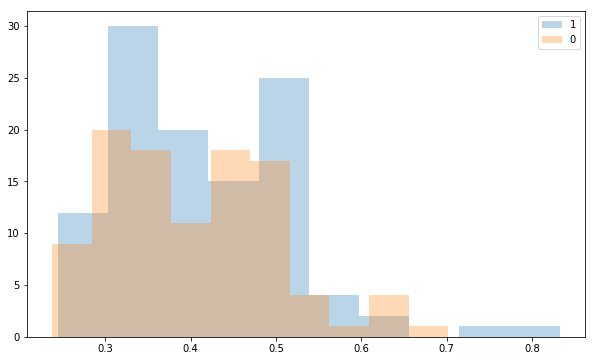

In [137]:
d = data[data['operator'] == 'bot']
print(stats.pointbiserialr(d['discriminator_score'], d['is_meaningful']))
print(d.groupby('is_meaningful').mean())

# pd.crosstab(0,[d['discriminator_score'], d['is_meaningful']])
plt.hist(d[d['is_meaningful']==1]['discriminator_score'].values, label='1', alpha=0.3, bins=10)
plt.hist(d[d['is_meaningful']==0]['discriminator_score'].values, label='0', alpha=0.3, bins=10)
plt.legend()
plt.show()

Index(['chat_id', 'user', 'question_id', 'operator', 'question', 'answer',
       'time_asked', 'time_answered', 'is_meaningful', 'discriminator_score'],
      dtype='object')
overall 581 ([4.4327716065019758e-07, (-3.4501833062751697, 0.0005602060270171762)], [[66, 74], [42, 110], [73, 52]], 0.72368421052631582, 0.52857142857142858, 0.41599999999999998)


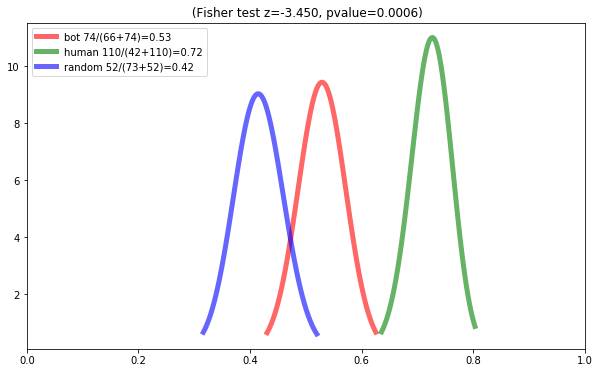

In [134]:
print(data.columns)

c = compare(data)
print('overall', len(data), c)

_, [bot, human, rnd], *_2 = c
plot_beta(bot, human, rnd)
plt.show()

### Статистика по толокерам персонально

Aleksey@yoptar 40 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Alexey@ 82 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Denis@kudep 31 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Eugeniya 🐙@fogside 51 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Evgeniy@varenick00 31 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Leonid@leonidpugachev 20 ([1.5939996783277835e-06, (-3.2758084123038125, 0.00

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)



Mary@vimary 28 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Mikhail@MBurtsev 67 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Mikhail@mikhail_arkhipov 52 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Rafael@ai_rafael 50 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)
Yura@yurakuratov 40 ([1.5939996783277835e-06, (-3.2758084123038125, 0.0010536000746794746)], [[63, 67], [40, 98], [65, 46]], 0.71014492753623193, 0.51538461538461533, 0.4144144144144144)


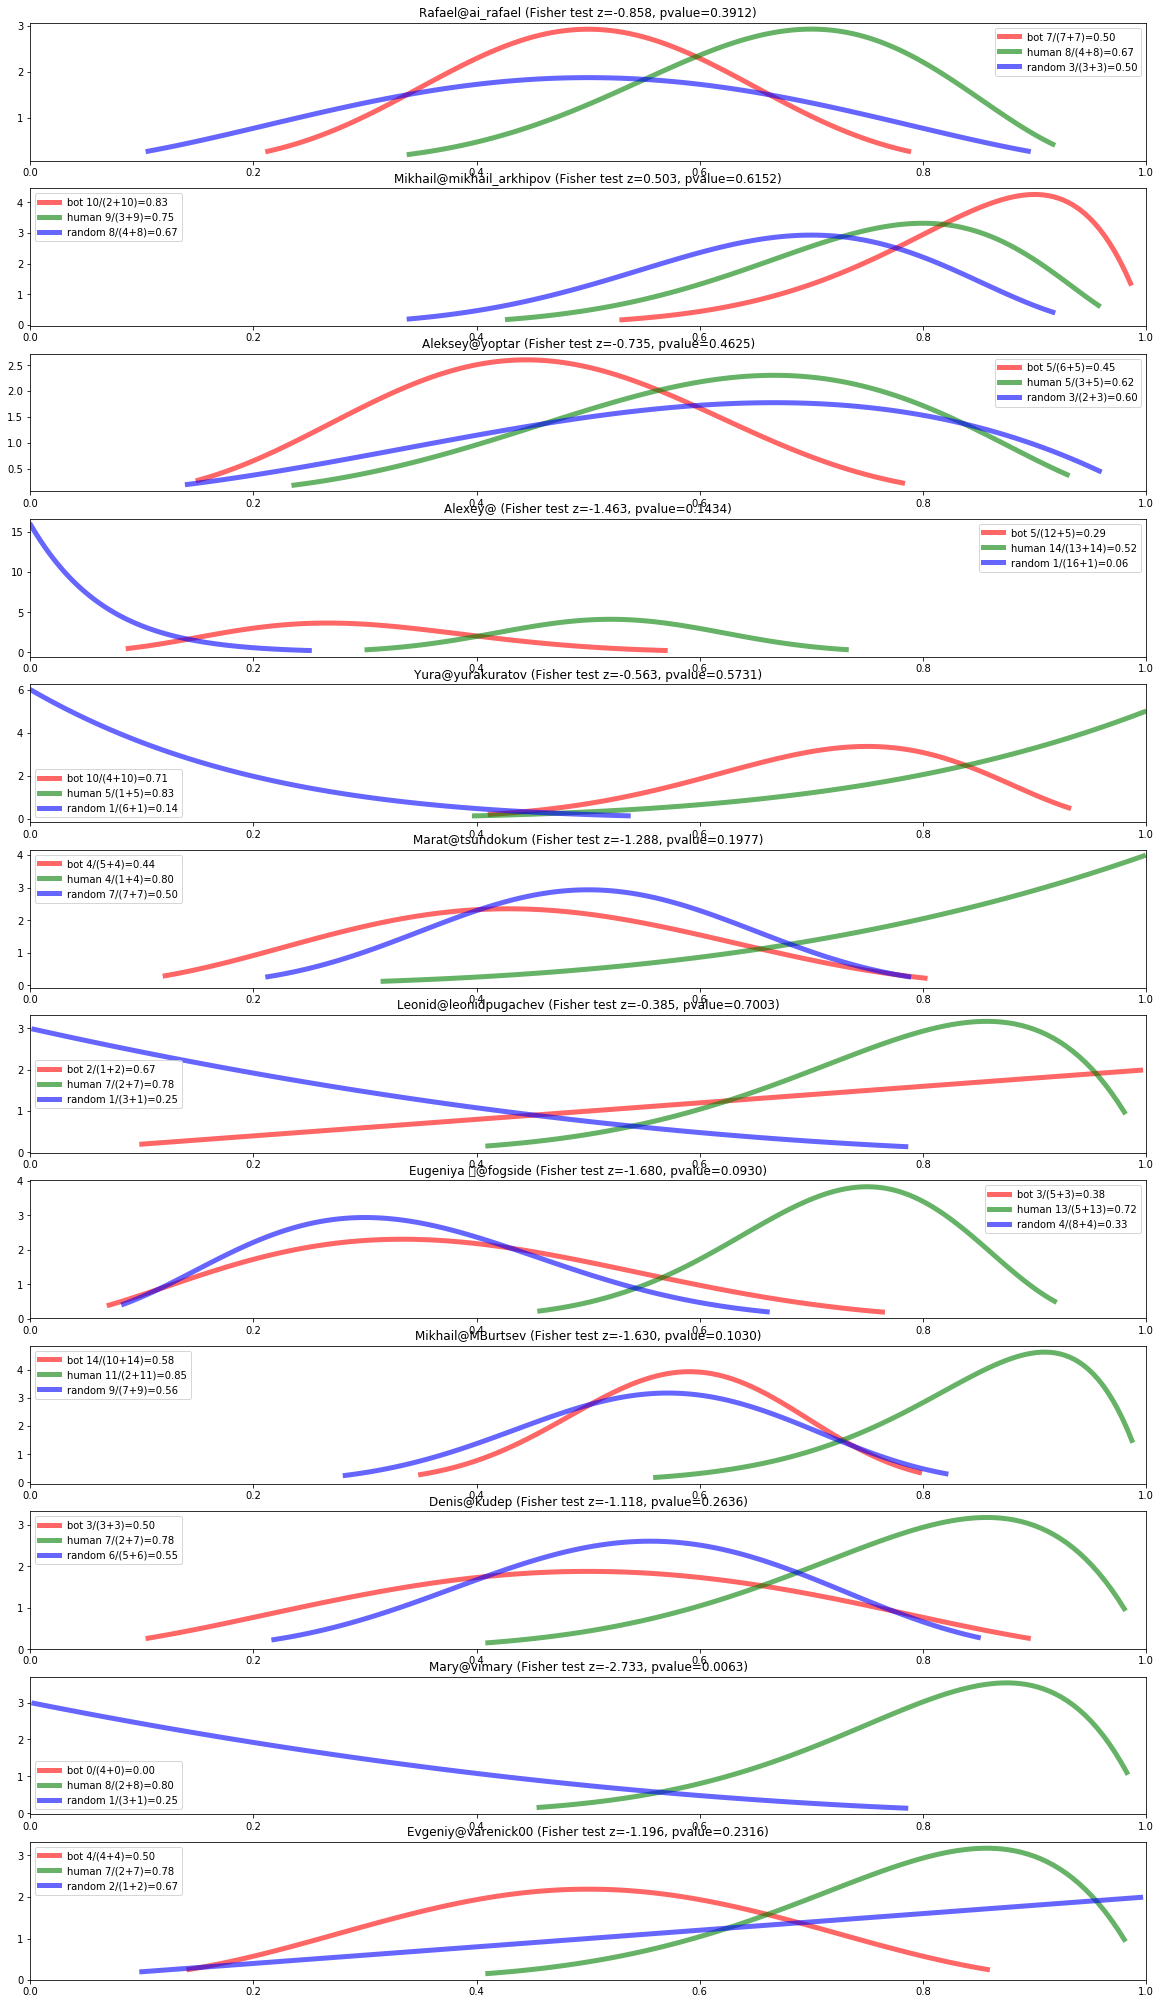

In [52]:
order = {c: i for i, c in enumerate(data['user'].unique())}

plt.figure(figsize=(20, len(order)*3))
for g, d in data.groupby('user'):
    try:
        _, [bot, human, rnd], *__ = compare(d, eps=0.1)
        plt.subplot(len(order), 1, order[g]+1)
        plot_beta(bot, human, rnd, title=g, legend=True)
        print(g, len(d), c)
    except KeyError as ex:
        print(ex)
    except ZeroDivisionError:
        print('\t>>> Not enough data for {}'.format(g))
plt.show()

### Статистика по новым и опытным толокерам

In [ ]:
data.user.unique()

In [ ]:
# exp_users = ['Alexey@', 'Mikhail@MBurtsev', 'Mikhail@mikhail_arkhipov',
#        'Aleksey@yoptar', 'Dilyara@bdilya', 'Mary@vimary',
#        'Marat@tsundokum', 'Varvara@varvara_konstantinovna', 'Eugeniya 🐙@fogside',
#             'Yura@yurakuratov']
# new_users = ['Roman@', 'Maksim@', 'Leonid@leonidpugachev', 'Olga@olgalind', 'Anatoly@anatoliipotapov']

# def newbie(username):
#     if username in new_users:
#         return 'newbie'
#     elif username in exp_users:
#         return 'expert'
#     else:
#         return 'unknown'


# data['newbie'] = data['user'].apply(newbie)

# order = {c: i for i, c in enumerate(data['newbie'].unique())}

# for g, d in data.groupby('newbie'):
#     try:
#         c = compare(d)
#         _, [bot, human, rnd], *_2 = c
#         print(g, len(d), )
#         plt.subplot(2, 1, order[g]+1)
#         plot_beta(bot, human, rnd, title=g)
#     except KeyError as ex:
#         print(ex)
# plt.show()        

### Влияние дискриминатора


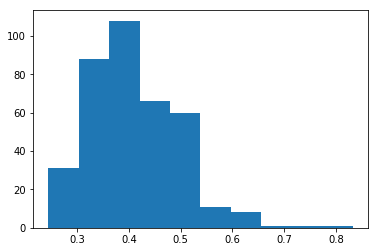

In [53]:
v = data['discriminator_score'].values
plt.hist(v[~np.isnan(v)])
plt.show()

In [68]:
datadata['operator'] == 'bot')

200

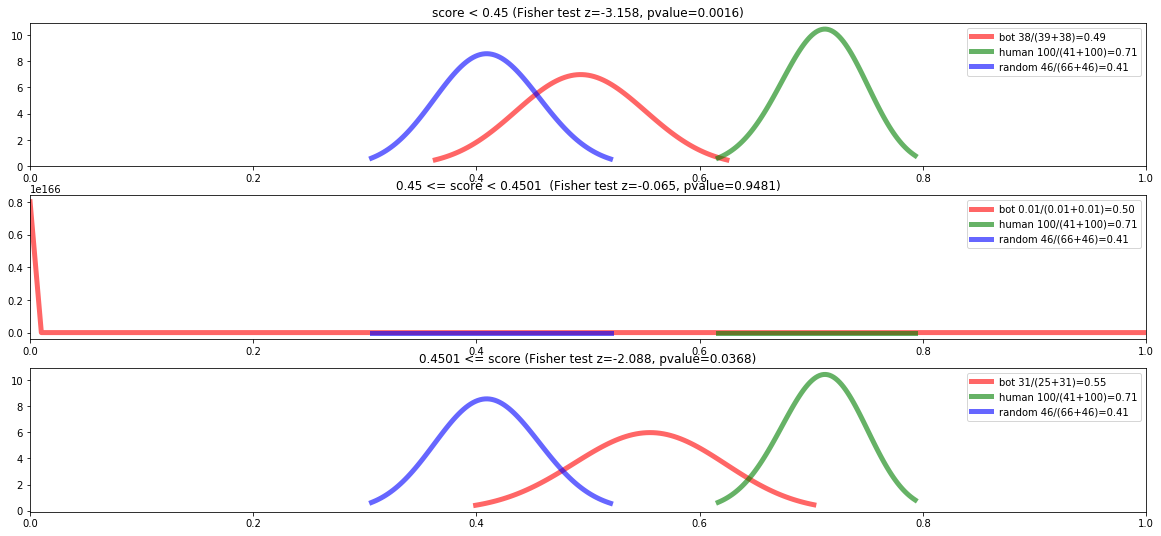

In [67]:
t1 = 0.45
t2 = 0.4501
data['score_class'] = np.digitize(data['discriminator_score'], [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'score < {t1}'),
                              (1, f'{t1} <= score < {t2} '),
                              (2, f'{t2} <= score')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['operator'] != 'bot') | ((data['operator'] == 'bot') & (data['score_class'] == class_id))
    _, [human, bot, rnd], *__ = compare(data[k])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

### Влияние длинны вопроса

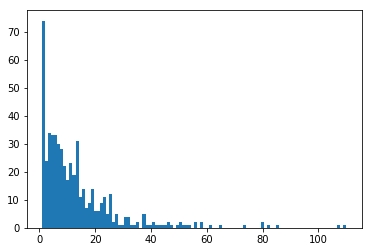

In [55]:
plt.hist(data['question'].apply(lambda x: len(word_tokenize(x))), bins=100)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/proportion.py:786: RuntimeWarning: invalid value encountered in true_divide
  prop = count * 1. / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/proportion.py:802: RuntimeWarning: divide by zero encountered in true_divide
  nobs_fact = np.sum(1. / nobs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= s

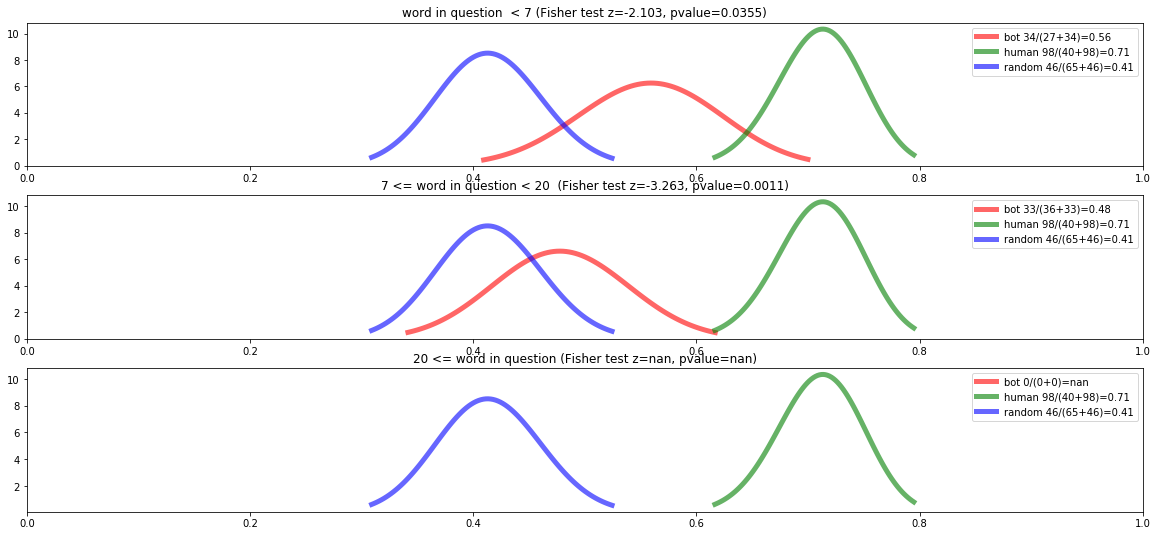

In [56]:
t1 = 7
t2 = 20
data['question_len_class'] = np.digitize(data['question'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'word in question  < {t1}'),
                              (1, f'{t1} <= word in question < {t2} '),
                              (2, f'{t2} <= word in question')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['operator'] != 'bot') | ((data['operator'] == 'bot') & (data['question_len_class'] == class_id))
    _, [human, bot, rnd], *__ = compare(data[k])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

### Влияние длины вопроса

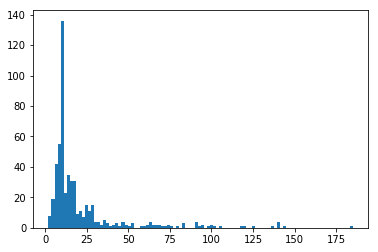

In [57]:
plt.hist(data['answer'].apply(lambda x: len(word_tokenize(x))), bins=100)
plt.show()

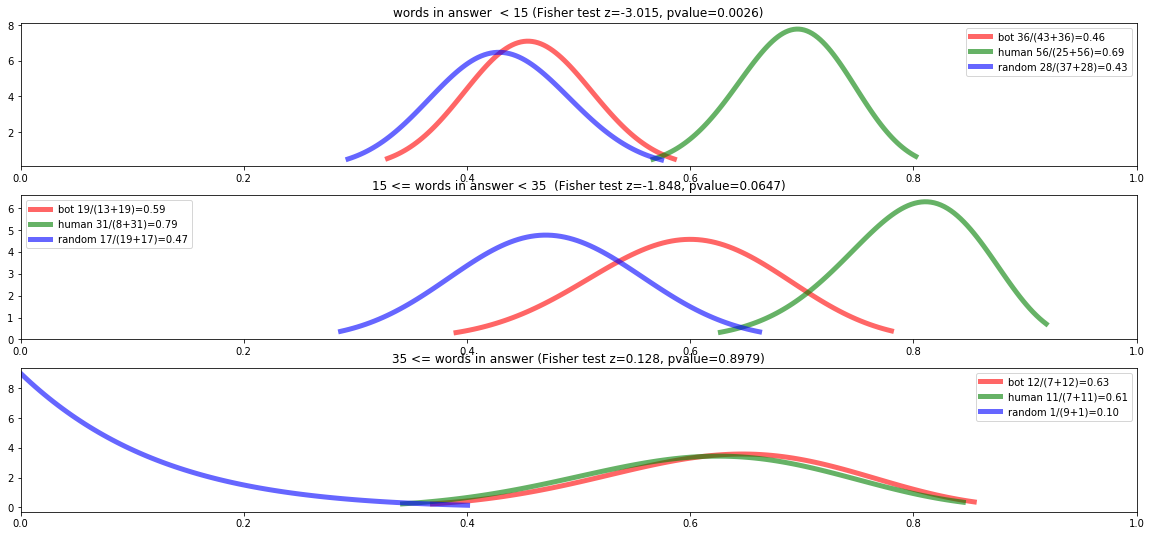

In [58]:
t1 = 15
t2 = 35
data['answer_len_class'] = np.digitize(data['answer'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'words in answer  < {t1}'),
                              (1, f'{t1} <= words in answer < {t2} '),
                              (2, f'{t2} <= words in answer')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['answer_len_class'] == class_id)
    _, [human, bot, rnd], *__ = compare(data[k])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

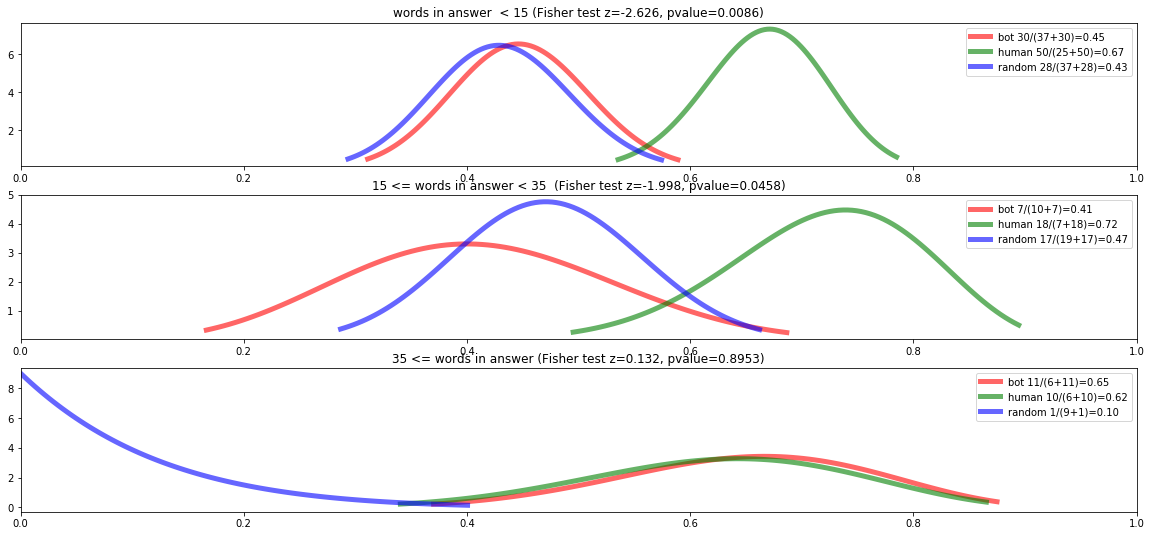

In [60]:
t1 = 15
t2 = 35
data['answer_len_class'] = np.digitize(data['answer'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'words in answer  < {t1}'),
                              (1, f'{t1} <= words in answer < {t2} '),
                              (2, f'{t2} <= words in answer')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['answer_len_class'] == class_id)
    _, [human, bot, rnd], *__ = compare(data[k & ((data['operator'] == 'random') | (data['discriminator_score'] < 0.5))])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


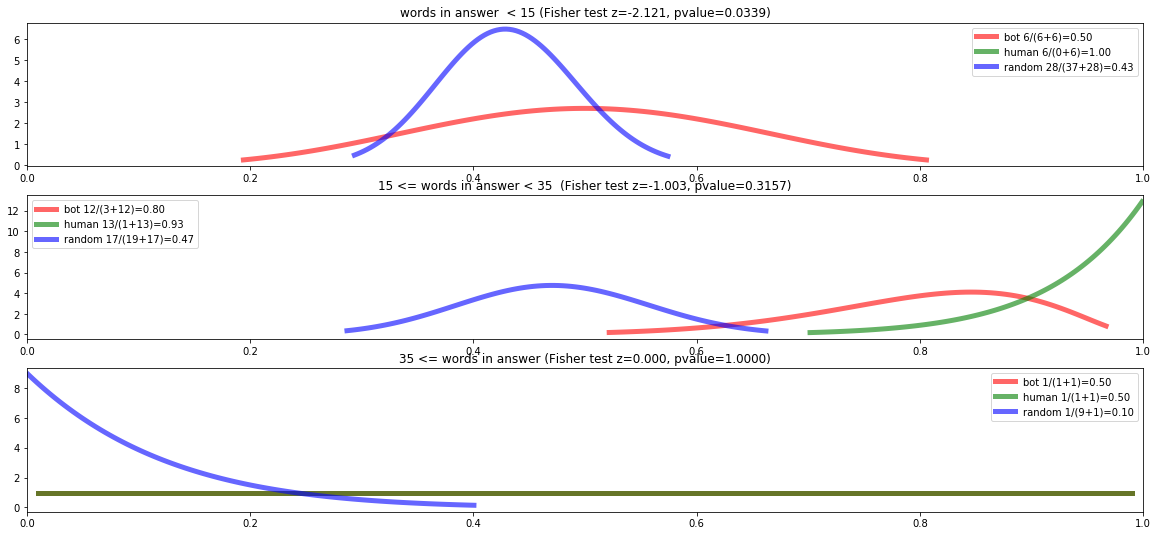

In [61]:
t1 = 15
t2 = 35
data['answer_len_class'] = np.digitize(data['answer'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'words in answer  < {t1}'),
                              (1, f'{t1} <= words in answer < {t2} '),
                              (2, f'{t2} <= words in answer')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['answer_len_class'] == class_id)
    _, [human, bot, rnd], *__ = compare(data[k & ((data['operator'] == 'random') | (data['discriminator_score'] >= 0.5))])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

In [ ]:
def get_question(text):
    context, answer = text.strip().split('<ANS_START>')
    cs = context.replace('<COR_START>', ';').replace('<MAN_START>', ';').replace('<PAUSE>', ';')
    cs = [c.strip() for c in cs.split(';') if c.strip()]
    if cs:
        return cs[-1]
    else:
        ''
    
q = pd.read_csv('downloads/sber2.csv', sep=',', quotechar='"')['Text'].apply(get_question)


In [ ]:
dt = datetime(2017, 11, 21, 15, 0)

c = compare(data[data['time_asked'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f")) > dt])
print('overall', len(data), c)

_, [bot, human, rnd], *_2 = c
plot_beta(bot, human, rnd)
plt.show()

In [ ]:
import marisa_trie

In [ ]:
trie = marisa_trie.Trie(['key1', 'key2', 'key12', 'key123'])

In [ ]:
for p in trie.keys('key1'):
    print(p)